In [1]:
import scipy as sc
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# BACKGROUND - define useful functions

# gives X(z) as defined in (8) Wang and Mota (note - k vanishes when calculating X)

def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + Omega_r * (1 + z)** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)

# gives E(z) = H(z) / H0

def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k + \
                   alpha_tilde*(1 - 2*Omega_k + Omega_k**2)

    if alpha_tilde == 0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2*alpha_tilde*Omega_k*(1+z)**2))/(2 * alpha_tilde))
    
    return ans

# gives dE/dz

def dEdz(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b
    
    # Wang and Mota
    dEdz = ((3 * Omega_m * (1 + z) ** 2) + (4 * Omega_r * (1 + z) ** 3) + (2 * Omega_k * (1 + z)))/(2 * E(z , cosmo) * np.sqrt(X(z , cosmo)))
    
    return dEdz

In [3]:
# PERTURBATIONS - define useful functions

# returns second derivative of Delta_m with respect to z given Delta_m
def ddDeltaddz (Delta , dDeltadz , z , cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde = cosmo
    Omega_m = Omega_c + Omega_b

    Eval = E(z , cosmo)
    Edash = dEdz(z , cosmo)
    
    ddDeltaddz = -1 * ((Edash / Eval - 1 / (1 + z)) * dDeltadz + (3 * Omega_m * (1 + z) * (2 * alpha_tilde * Eval * (2 * (1 + z) * Edash - Eval) - 1)*Delta/ \
    (2 * Eval ** 2 * (2 * alpha_tilde * Eval ** 2 + 1))))
    
    #ddDeltaddz = -1 * ((Edash / Eval - 1 / (1 + z)) * dDeltadz + (3 * Omega_m * (1 + z) * (2 * alpha_tilde * Eval * (2 * (1 + z) * Edash - Eval) - 1)*Delta/ \
    #(2 * (2 * alpha_tilde * Eval ** 2 + 1)**2)))
    return ddDeltaddz


def coupled_Delta_dDeltadz(y , z , cosmo):
    Delta , dDeltadz = y
    ydot = [dDeltadz, ddDeltaddz(Delta , dDeltadz , z , cosmo)]
    return ydot

In [4]:
# Define constants

cosmo = [0.27 , 0.045 , 0 , 9.2e-5 , 0]                     #  Omega_c , Omega_b , Omega_k , Omega_r , alpha_tilde 


#create coord times (solve backwards and forwards in time from boundary condition)
p = 3
z = np.linspace(0, 20000, int(10**p))

BCs = [2,1]

#find solution
Soln = odeint(coupled_Delta_dDeltadz, BCs, z, args=(cosmo,), mxstep=int(1e4))

Delta = Soln[:,0]

dDeltadz = Soln[:,1]

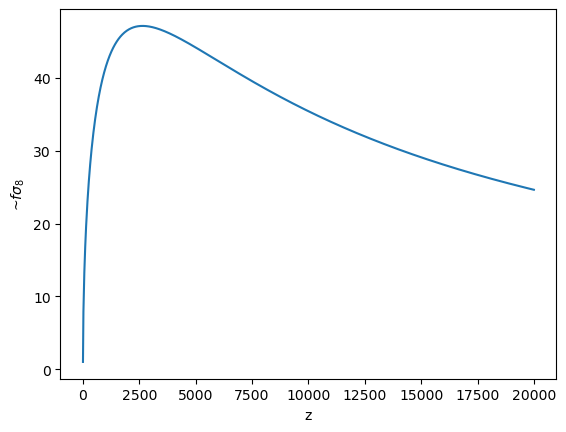

In [5]:
plt.plot(z, dDeltadz)

plt.xlabel("z")
plt.ylabel("~$f\sigma_8$")
plt.show()